In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import rasterio
from rasterio.plot import show
from utils import AvalancheFeatures, load_labels

In [2]:
# Define path to the data files
data_path = Path("../data/")
tif_files = list(data_path.glob("*.tif"))
results_path = Path("../results/")

In [3]:
# Load coordinates of avalanches and non-avalanches
avalanches_df = gpd.read_file(data_path / "Avalanches.shp")
non_avalanches_df = gpd.read_file(data_path / "Non avalanches.shp")

# Basic statistics
print(f'Num avalanches = {len(avalanches_df)}')

print(f'Num non-avalanches = {len(non_avalanches_df)}')

# Make sure they use the same Coordinate Reference System (CRS)
print(f'Using the same CRS = {avalanches_df.crs == non_avalanches_df.crs}')

Num avalanches = 100
Num non-avalanches = 136
Using the same CRS = True


In [ ]:
for file in tif_files:
    dataset = rasterio.open(data_path / file)
    fig, ax = plt.subplots()
    show(dataset, ax=ax, cmap='Blues')
    avalanches_df.plot(ax=ax, marker='x', color='r', label='avalanches')
    non_avalanches_df.plot(ax=ax, marker='o', facecolor='none', color='g', label='non avalanches')
    ax.legend()
    ax.set_title(file.stem)
    plt.show()

In [4]:
# Load the dataset in the form of a dataframe for easy analysis
labels = load_labels(
    avalanches_path=data_path/'Avalanches.shp',
    non_avalanches_path=data_path/'Non avalanches.shp'
)
features = AvalancheFeatures(
    tif_paths=[data_path/file for file in tif_files],
    coords=labels['geometry']
)

In [7]:
# Check for feature w/ low standard deviation
df_num = features.df.select_dtypes(include=['number', 'bool'])
df_num['avalanche'] = labels['avalanche']
df_num = df_num.drop(['precipitation', 'temperature'], axis=1)
norm_df = df_num - df_num.mean()
norm_df /= df_num.abs().max()
print('Standard deviations')
print(norm_df.std())

Standard deviations
snow_index           0.386133
plan_curvature       0.123123
profile_curvature    0.267416
slope                0.197127
elevation            0.216687
avalanche            0.495479
dtype: object


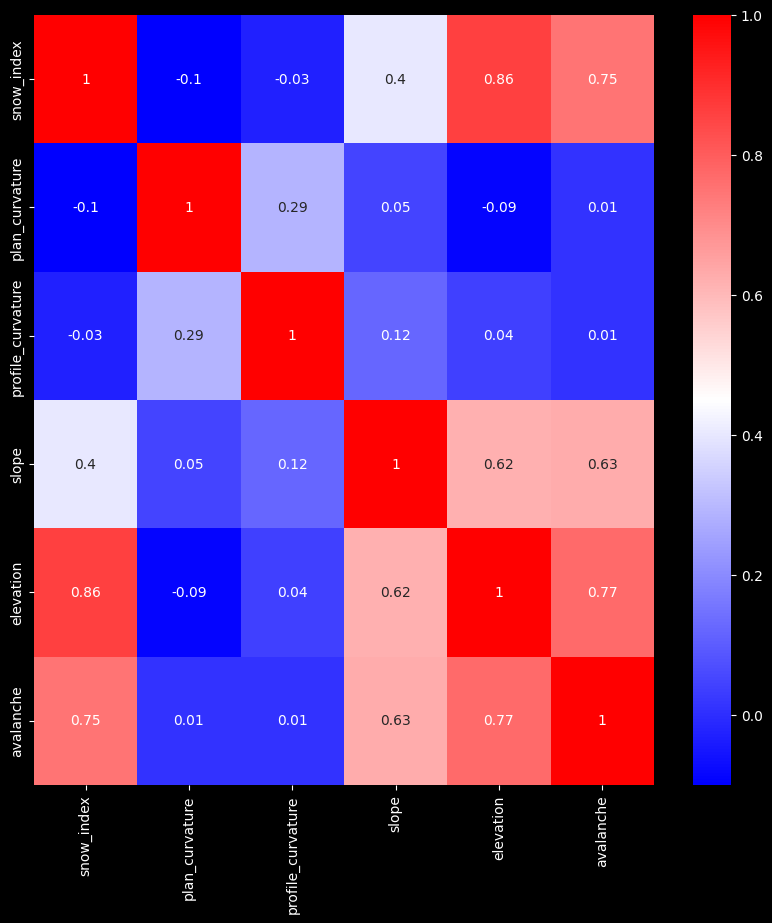

In [45]:
# Check for correlation between variables
plt.figure(figsize=(10, 10))
sns.heatmap(df_num.corr().round(2), annot=True, cmap='bwr')
plt.show()

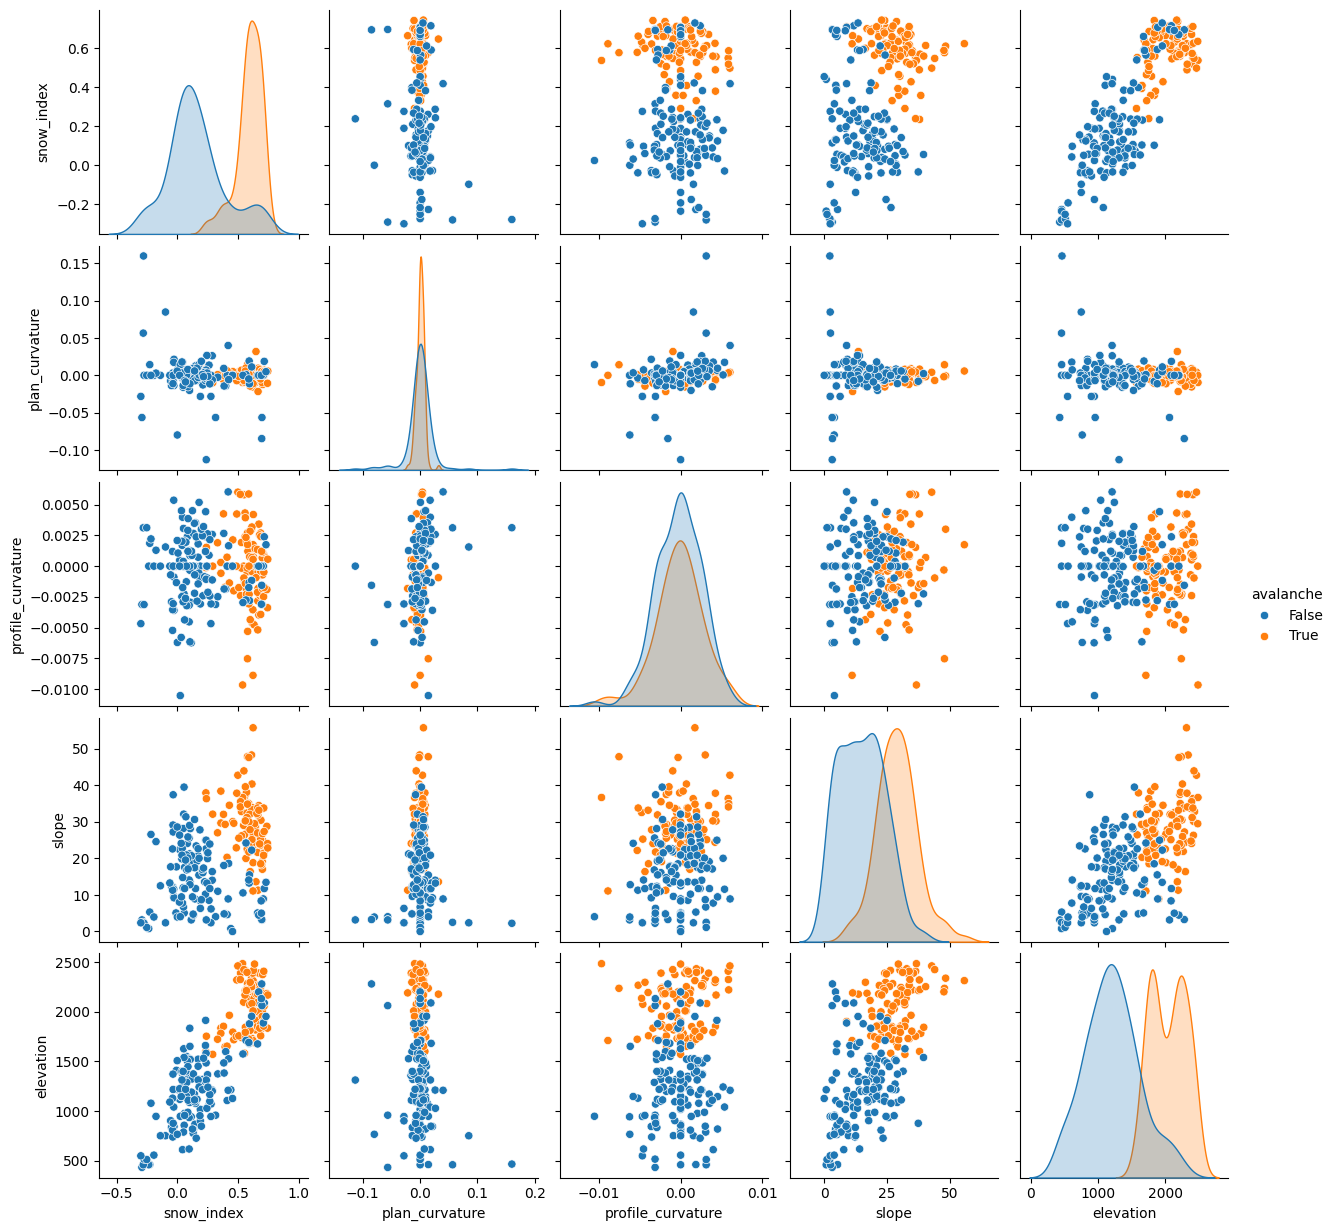

In [8]:
sns.pairplot(df_num, hue='avalanche')
plt.show()

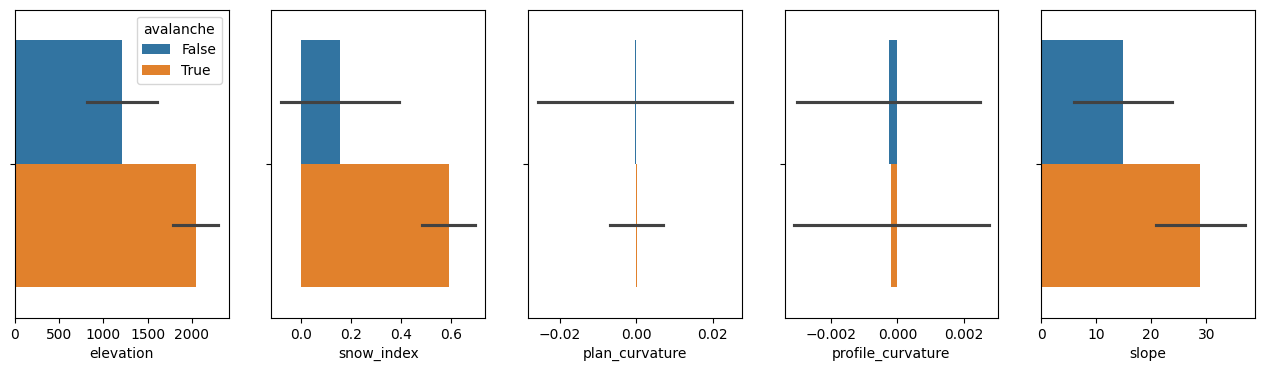

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
sns.barplot(df_num, x='elevation', hue='avalanche', errorbar='sd', ax=ax[0])
for i, feat in enumerate(['snow_index', 'plan_curvature', 'profile_curvature', 'slope']):
    sns.barplot(df_num, x=feat, hue='avalanche', errorbar='sd', ax=ax[1+i], legend=False)
plt.show()

In [9]:
df_cat = features.df[['geometry', 'land_use', 'aspect']]
df_cat = df_cat.sjoin(labels, how='left').drop('index_right', axis=1)

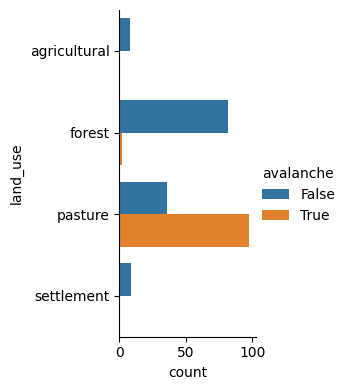

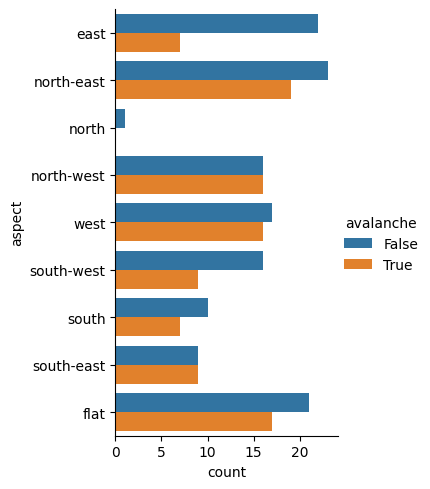

In [13]:
sns.catplot(df_cat, y='land_use', hue='avalanche', kind='count', aspect=0.75, height=4)
plt.savefig(results_path / 'land_use.png', bbox_inches='tight', dpi=300)
sns.catplot(
    df_cat, y='aspect', hue='avalanche', kind='count', aspect=0.75,
    order=[
        'east', 'north-east', 'north', 'north-west', 'west', 
        'south-west', 'south', 'south-east', 'flat'
    ]
)
plt.savefig(results_path / 'aspect.png', bbox_inches='tight', dpi=300)
plt.show()

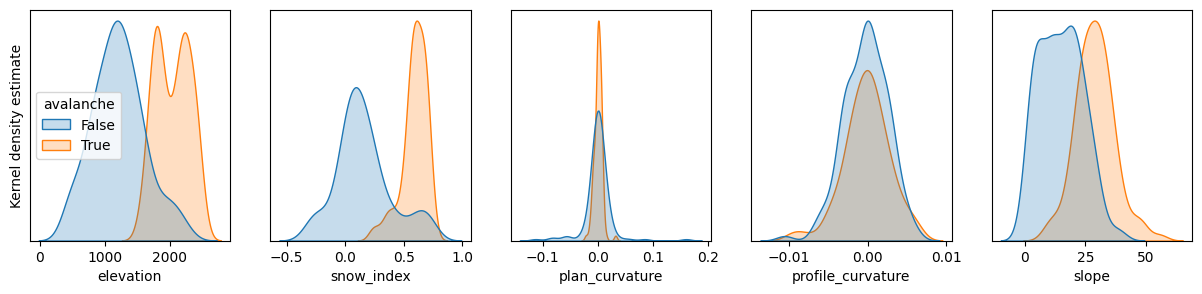

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
sns.kdeplot(df_num, x='elevation', hue='avalanche', ax=ax[0], fill=True)
for i, feat in enumerate(['snow_index', 'plan_curvature', 'profile_curvature', 'slope']):
    sns.kdeplot(df_num, x=feat, hue='avalanche', ax=ax[1+i], legend=False, fill=True)
for a in ax:
    a.set_yticks([])
    a.set_ylabel('')
ax[0].set_ylabel('Kernel density estimate')
plt.savefig(results_path / 'kdes.png', bbox_inches='tight', dpi=300)
plt.show()

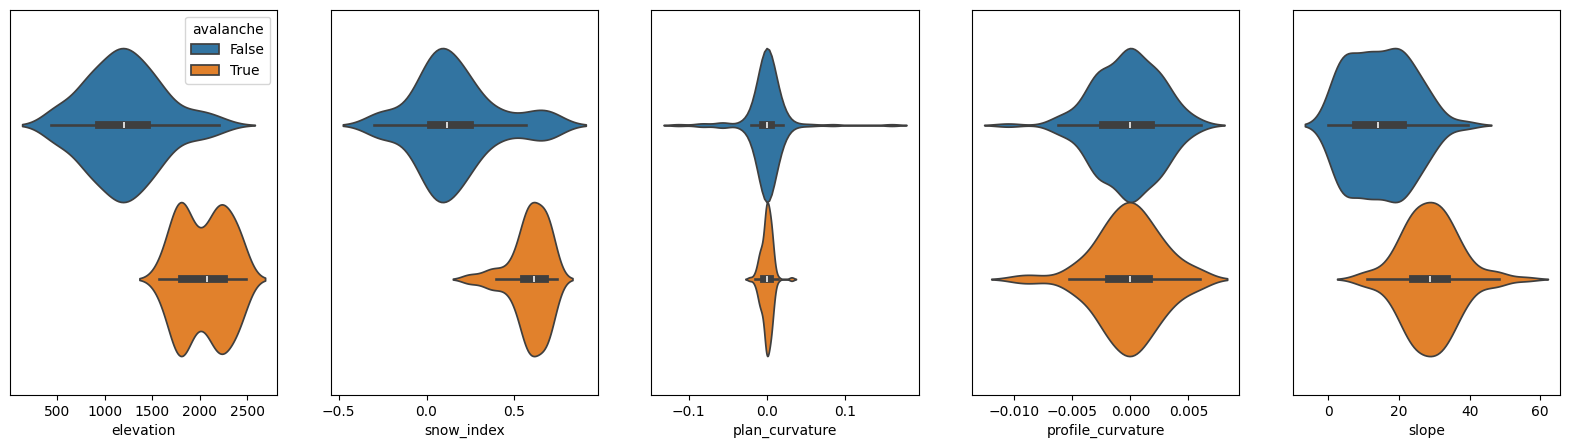

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
sns.violinplot(df_num, x='elevation', hue='avalanche', ax=ax[0])
for i, feat in enumerate(['snow_index', 'plan_curvature', 'profile_curvature', 'slope']):
    sns.violinplot(df_num, x=feat, hue='avalanche', ax=ax[1+i], legend=False)
for a in ax:
    a.set_yticks([])
    a.set_ylabel('')
plt.show()